In [5]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import gc

In [6]:
dir_path='./'
file_train = 'train.csv'
file_questions = 'questions.csv'
file_lectures = 'lectures.csv'

In [7]:
nrows = 100*10000

In [10]:
train = pd.read_csv(
                    dir_path+file_train,
                    nrows=nrows,
                    usecols=['row_id','timestamp','user_id','content_id','content_type_id','task_container_id','answered_correctly',
                             'prior_question_elapsed_time','prior_question_had_explanation'],
                    dtype={
                        'row_id':'int64',
                        'timestamp':'int64',
                        'user_id':'int32',
                        'content_id':'int8',
                        'content_type_id':'int8',
                        'task_container_id':'int8',
                        'answered_correctly':'int8',
                        'prior_question_elapsed_time':'float32',
                        'prior_question_had_explanation': 'str'
                    }
                   )

In [12]:
lectures = pd.read_csv(
                    dir_path+file_lectures,
                    usecols=['lecture_id','tag','part','type_of'],
                    nrows=nrows,
                    dtype={
                        'lecture_id':'int16',
                        'tag':'int16',
                        'part':'int8',
                        'type_of':'str'
                    }
                )

In [13]:
questions = pd.read_csv(
                    dir_path+file_questions,
                    usecols=['question_id','bundle_id','part','tags'],
                    dtype={
                        'question_id':'int16',
                        'bundle_id':'int16',
                        'part':'int8',
                        'tags':'str'
                    }
                )

In [14]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,60,0,1,1,NaN,NaN
1,1,56943,115,84,0,2,1,37000.0,False
2,2,118363,115,-128,0,0,1,55000.0,False
3,3,131167,115,-76,0,3,1,19000.0,False
4,4,137965,115,-14,0,4,1,11000.0,False


In [15]:
questions.head()

,question_id,bundle_id,part,tags
0,0,0,1,51 131 162 38
1,1,1,1,131 36 81
2,2,2,1,131 101 162 92
3,3,3,1,131 149 162 29
4,4,4,1,131 5 162 38


In [16]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

/root/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Text(0.5, 1.0, 'label dis')

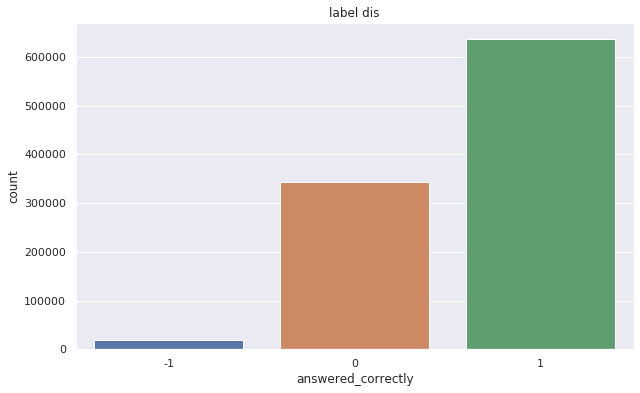

In [18]:
sns.set()
plt.figure(figsize=(10,6))
sns.countplot(data=train,x='answered_correctly')
plt.title('label dis')

数据字段分析

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   row_id                          1000000 non-null  int64  
 1   timestamp                       1000000 non-null  int64  
 2   user_id                         1000000 non-null  int32  
 3   content_id                      1000000 non-null  int8   
 4   content_type_id                 1000000 non-null  int8   
 5   task_container_id               1000000 non-null  int8   
 6   answered_correctly              1000000 non-null  int8   
 7   prior_question_elapsed_time     976277 non-null   float32
 8   prior_question_had_explanation  996184 non-null   object 
dtypes: float32(1), int32(1), int64(2), int8(4), object(1)
memory usage: 34.3+ MB


In [23]:
train.groupby(['user_id'])['row_id'].count().reset_index()

,user_id,row_id
0,115,46
1,124,30
2,2746,20
3,5382,128
4,8623,112
...,...,...
3819,20913319,416
3820,20913864,21
3821,20938253,535
3822,20948951,51


In [25]:
d=train.groupby(['user_id'])['row_id'].count().reset_index()
d.sort_values(['row_id'])

,user_id,row_id
3661,19887248,1
308,1880240,1
2932,15960740,2
366,2148001,2
318,1946295,3
...,...,...
796,4421282,6962
1707,9418512,7482
218,1283420,7569
3329,18122922,7593


In [27]:
train[train['user_id']==19887248]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
965193,965193,0,19887248,-32,0,0,0,NaN,NaN


In [33]:
d = train.groupby(['user_id'])['answered_correctly'].agg([np.mean]).reset_index()

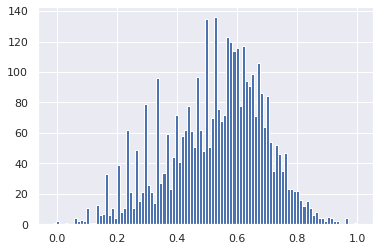

In [34]:
d['mean'].hist(bins=100)

In [35]:
from collections import Counter

In [36]:
Counter(train[train['user_id']==7171715]['content_type_id'])

Counter({0: 10797, 1: 29})

In [39]:
train[train['answered_correctly']!=-1].groupby(['user_id'])['answered_correctly'].agg([np.mean,np.std,np.max]).reset_index()

,user_id,mean,std,amax
0,115,0.695652,0.465215,1
1,124,0.233333,0.430183,1
2,2746,0.578947,0.507257,1
3,5382,0.672000,0.471374,1
4,8623,0.642202,0.481566,1
...,...,...,...,...
3819,20913319,0.630653,0.483235,1
3820,20913864,0.333333,0.483046,1
3821,20938253,0.608779,0.488490,1
3822,20948951,0.607843,0.493089,1


用户行为次数分布

Text(0, 0.5, 'Pro')

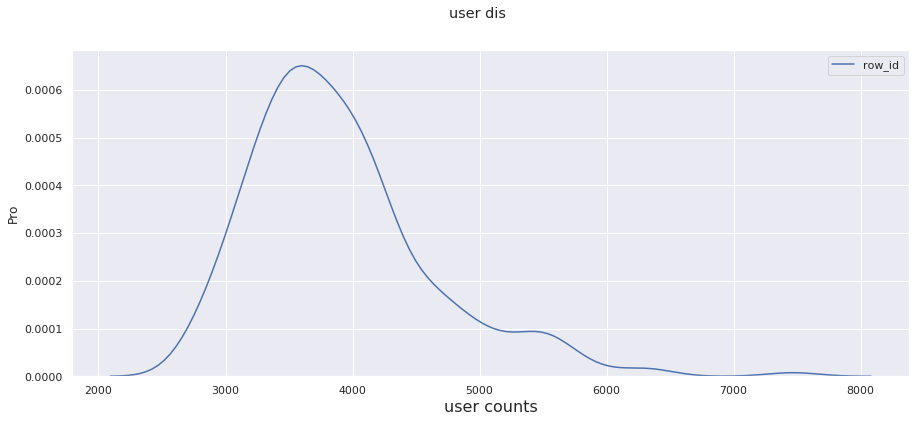

In [44]:
sns.set()
fig = plt.figure(figsize=(15,6))
fig = sns.kdeplot(train.groupby(by='content_id')['row_id'].count())
fig.figure.suptitle('user dis')
plt.xlabel('user counts',fontsize=16)
plt.ylabel('Pro')

In [45]:
Counter(questions.part)

Counter({1: 992, 2: 1647, 3: 1562, 4: 1439, 5: 5511, 6: 1212, 7: 1160})

In [46]:
questions['part_1'] = questions['part'].map(lambda x : 1 if x==1 else 0)
questions['part_2'] = questions['part'].map(lambda x: 1 if x==2 else 0)

In [47]:
questions.head()

,question_id,bundle_id,part,tags,part_1,part_2
0,0,0,1,51 131 162 38,1,0
1,1,1,1,131 36 81,1,0
2,2,2,1,131 101 162 92,1,0
3,3,3,1,131 149 162 29,1,0
4,4,4,1,131 5 162 38,1,0


In [48]:
questions.tags.map(lambda x: str(x).split(' '))

0         [51, 131, 162, 38]
1              [131, 36, 81]
2        [131, 101, 162, 92]
3        [131, 149, 162, 29]
4          [131, 5, 162, 38]
                ...         
13518                   [14]
13519                    [8]
13520                   [73]
13521                  [125]
13522                   [55]
Name: tags, Length: 13523, dtype: object

In [50]:
tags_list = []
for c in questions.tags.map(lambda x:str(x).split(' ')):
    tags_list += c
Counter(tags_list)

Counter({'51': 71,
         '131': 650,
         '162': 914,
         '38': 2256,
         '36': 35,
         '81': 1969,
         '101': 52,
         '92': 2269,
         '149': 53,
         '29': 1707,
         '5': 85,
         '10': 293,
         '94': 27,
         '61': 49,
         '110': 49,
         '13': 24,
         '164': 56,
         '99': 36,
         '93': 58,
         '70': 46,
         '9': 124,
         '104': 72,
         '40': 27,
         '130': 37,
         '187': 45,
         '102': 789,
         '111': 38,
         '178': 39,
         '143': 712,
         '30': 105,
         '90': 214,
         '100': 203,
         '176': 105,
         '140': 112,
         '6': 8,
         '2': 144,
         '107': 120,
         '114': 121,
         '138': 104,
         '41': 100,
         '141': 65,
         '137': 115,
         '142': 17,
         '119': 93,
         '148': 110,
         '69': 69,
         '62': 194,
         '155': 209,
         '163': 132,
         '129': 50,

In [51]:
len(set(tags_list))

189

In [52]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [53]:
Counter(lectures.tag)

Counter({159: 4,
         70: 5,
         45: 3,
         79: 4,
         156: 4,
         114: 5,
         179: 4,
         134: 6,
         93: 2,
         80: 3,
         98: 3,
         101: 4,
         33: 3,
         74: 6,
         60: 3,
         181: 4,
         43: 3,
         4: 4,
         109: 4,
         89: 3,
         142: 2,
         140: 2,
         104: 2,
         1: 4,
         65: 3,
         155: 1,
         26: 4,
         178: 2,
         173: 5,
         7: 3,
         147: 2,
         171: 1,
         78: 2,
         62: 6,
         64: 4,
         141: 3,
         124: 2,
         161: 6,
         24: 2,
         23: 2,
         152: 4,
         8: 4,
         94: 5,
         119: 5,
         37: 2,
         177: 3,
         54: 3,
         157: 4,
         132: 2,
         6: 2,
         67: 1,
         123: 3,
         50: 2,
         25: 3,
         175: 2,
         116: 6,
         136: 7,
         20: 2,
         129: 3,
         127: 3,
         53: 4,

In [54]:
Counter(lectures.part)

Counter({5: 143, 1: 54, 6: 83, 2: 56, 7: 32, 3: 19, 4: 31})

In [55]:
Counter(lectures.type_of)

Counter({'concept': 222,
         'solving question': 186,
         'intention': 7,
         'starter': 3})